# HW07 – Кластеризация и внутренние метрики качества

**Датасеты:** 01, 02, 04

In [38]:
import os
import json
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use("default")

## 1. Загрузка данных и первичный анализ

### 1.1 Датасет 01

In [39]:
df1 = pd.read_csv("data/S07-hw-dataset-01.csv")

df1.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [40]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [41]:
df1.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [42]:
# sample_id отдельно, X без sample_id
sample_ids1 = df1["sample_id"].copy()
X1 = df1.drop(columns=["sample_id"])

# Пропуски: количество и доля
missing_cnt1 = X1.isna().sum()
missing_pct1 = (X1.isna().mean() * 100).round(2)
missing_summary1 = pd.DataFrame({"missing_cnt": missing_cnt1, "missing_pct": missing_pct1})
missing_summary1[missing_summary1["missing_cnt"] > 0]

,missing_cnt,missing_pct


In [43]:
# Типы признаков (по X)
num_cols1 = X1.select_dtypes(include=[np.number]).columns.tolist()
cat_cols1 = X1.select_dtypes(exclude=[np.number]).columns.tolist()
pd.Series({"n_numeric": len(num_cols1), "n_categorical": len(cat_cols1)})

n_numeric        8
n_categorical    0
dtype: int64

### 1.2 Датасет 02

In [44]:
df2 = pd.read_csv("data/S07-hw-dataset-02.csv")

df2.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [45]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [46]:
df2.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [47]:
# sample_id отдельно, X без sample_id
sample_ids2 = df2["sample_id"].copy()
X2 = df2.drop(columns=["sample_id"])

# Пропуски: количество и доля
missing_cnt2 = X2.isna().sum()
missing_pct2 = (X2.isna().mean() * 100).round(2)
missing_summary2 = pd.DataFrame({"missing_cnt": missing_cnt2, "missing_pct": missing_pct2})
missing_summary2[missing_summary2["missing_cnt"] > 0]

,missing_cnt,missing_pct


In [48]:
# Типы признаков (по X)
num_cols2 = X2.select_dtypes(include=[np.number]).columns.tolist()
cat_cols2 = X2.select_dtypes(exclude=[np.number]).columns.tolist()
pd.Series({"n_numeric": len(num_cols2), "n_categorical": len(cat_cols2)})

n_numeric        3
n_categorical    0
dtype: int64

### 1.3 Датасет 04

In [49]:
# Загрузка CSV
df4 = pd.read_csv('data/S07-hw-dataset-04.csv')

df4.head()

,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676


In [50]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-null   float64
 20  n18    

In [51]:
df4.describe()

,sample_id,n01,n02,n03,n04,n05,n06,n07,n08,n09,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
count,10000.00000,9826.000000,9811.000000,9801.000000,9808.000000,9799.000000,9817.000000,9796.000000,9806.000000,9805.000000,...,9785.000000,9804.000000,9829.000000,9793.000000,9815.000000,9776.000000,9803.000000,9789.000000,9798.000000,9805.000000
mean,4999.50000,17.348435,-2.057620,7.908302,14.269157,0.900590,5.832787,-0.840875,-4.888128,3.184200,...,-12.716502,-0.506241,8.360226,0.026943,0.039297,-0.037155,0.028512,-0.030738,-0.018685,-0.030254
std,2886.89568,22.578551,19.043410,25.637807,18.815319,20.981294,13.221646,26.583849,15.466271,32.208740,...,37.290305,14.336833,17.754646,26.121335,3.009995,3.020813,3.028106,3.000090,3.014209,3.014573
min,0.00000,-22.437090,-37.546998,-38.136412,-23.374316,-45.914070,-20.650038,-60.297304,-44.464550,-70.904880,...,-89.640783,-35.102360,-25.014050,-49.423300,-11.225848,-14.446922,-10.840777,-11.679259,-11.437909,-11.491223
25%,2499.75000,-3.975438,-14.200552,-8.591513,-1.223379,-5.086756,-4.532057,-13.554720,-17.352641,-11.460490,...,-41.284671,-11.563652,-2.123576,-19.425213,-1.973213,-2.082235,-2.007628,-2.074500,-2.051778,-2.074396
50%,4999.50000,22.042807,-6.532183,0.350400,10.069142,2.413111,7.391953,-2.429024,-7.095546,13.258691,...,-1.145681,2.491416,6.691365,-8.464171,0.037806,-0.033336,0.031588,-0.043127,-0.015441,-0.015903
75%,7499.25000,37.535647,2.092197,30.725630,29.807101,18.398883,13.033076,16.095731,3.909111,20.188426,...,18.916379,11.903004,14.939690,16.861978,2.048648,2.019027,2.056870,1.980217,2.013964,2.031215
max,9999.00000,65.446912,43.326647,60.185729,65.094588,42.527554,39.933274,48.591236,31.335431,64.696045,...,49.157087,22.452135,46.892903,61.540902,11.002135,11.394631,11.936846,10.663960,10.665988,13.755203


In [52]:
# sample_id отдельно, X без sample_id
sample_ids4 = df4["sample_id"].copy()
X4 = df4.drop(columns=["sample_id"])

# Пропуски: количество и доля
missing_cnt4 = X4.isna().sum()
missing_pct4 = (X4.isna().mean() * 100).round(2)
missing_summary4 = pd.DataFrame({"missing_cnt": missing_cnt4, "missing_pct": missing_pct4})
missing_summary4[missing_summary4["missing_cnt"] > 0]

,missing_cnt,missing_pct
n01,174,1.74
n02,189,1.89
n03,199,1.99
n04,192,1.92
n05,201,2.01
n06,183,1.83
n07,204,2.04
n08,194,1.94
n09,195,1.95
n10,189,1.89


In [53]:
# Типы признаков (по X)
num_cols4 = X4.select_dtypes(include=[np.number]).columns.tolist()
cat_cols4 = X4.select_dtypes(exclude=[np.number]).columns.tolist()
pd.Series({"n_numeric": len(num_cols4), "n_categorical": len(cat_cols4)})

n_numeric        30
n_categorical     2
dtype: int64

## 2. Препроцессинг

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Dataset 01: только числовые признаки -> StandardScaler
preprocessor1 = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
        ]), num_cols1),
    ],
    remainder="drop",
)
X1_processed = preprocessor1.fit_transform(X1)


# Dataset 02: только числовые признаки -> StandardScaler
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
        ]), num_cols2),
    ],
    remainder="drop",
)
X2_processed = preprocessor2.fit_transform(X2)


# Dataset 04: числовые + категориальные (+ пропуски)
numeric_transformer4 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

# OneHotEncoder: совместимость sklearn (sparse vs sparse_output)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer4 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", ohe),
])

preprocessor4 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer4, num_cols4),
        ("cat", categorical_transformer4, cat_cols4),
    ],
    remainder="drop",
)
X4_processed = preprocessor4.fit_transform(X4)


## 3. Кластеризация

In [59]:
def calculate_metrics(X, labels):
    """
    Внутренние метрики качества кластеризации.
    Для DBSCAN: если есть шум (-1), метрики считаем только по non-noise точкам.
    """
    X = np.asarray(X)
    labels = np.asarray(labels)

    has_noise = np.any(labels == -1)

    if has_noise:
        noise_ratio = float(np.mean(labels == -1))
        mask = labels != -1

        # Нужно хотя бы 2 кластера среди non-noise
        if mask.sum() > 1 and np.unique(labels[mask]).size > 1:
            X_eval = X[mask]
            y_eval = labels[mask]
            silhouette = silhouette_score(X_eval, y_eval)
            db_index = davies_bouldin_score(X_eval, y_eval)
            ch_index = calinski_harabasz_score(X_eval, y_eval)
        else:
            silhouette = db_index = ch_index = np.nan

        n_clusters = int(np.unique(labels[mask]).size)
    else:
        noise_ratio = 0.0
        if np.unique(labels).size > 1:
            silhouette = silhouette_score(X, labels)
            db_index = davies_bouldin_score(X, labels)
            ch_index = calinski_harabasz_score(X, labels)
        else:
            silhouette = db_index = ch_index = np.nan

        n_clusters = int(np.unique(labels).size)

    return {
        "silhouette": float(silhouette) if np.isfinite(silhouette) else np.nan,
        "davies_bouldin": float(db_index) if np.isfinite(db_index) else np.nan,
        "calinski_harabasz": float(ch_index) if np.isfinite(ch_index) else np.nan,
        "noise_ratio": float(noise_ratio),
        "n_clusters": int(n_clusters),
    }

### 3.1 Датасет 01: KMeans + DBSCAN

In [60]:
kmeans_results_1 = []
k_range = range(2, 21)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = model.fit_predict(X1_processed)

    m = calculate_metrics(X1_processed, labels)
    m["method"] = "KMeans"
    m["k"] = int(k)
    kmeans_results_1.append(m)

kmeans_df_1 = pd.DataFrame(kmeans_results_1)
kmeans_df_1[["k", "silhouette", "davies_bouldin", "calinski_harabasz"]].round(3)

,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.522,0.685,11786.955
1,3,0.397,0.965,10446.638
2,4,0.383,1.160,9427.500
3,5,0.355,1.274,8301.206
4,6,0.359,1.182,7333.388
5,7,0.325,1.194,6823.008
6,8,0.269,1.314,6460.801
7,9,0.253,1.344,6255.217
8,10,0.263,1.277,6084.503
9,11,0.266,1.214,5898.164


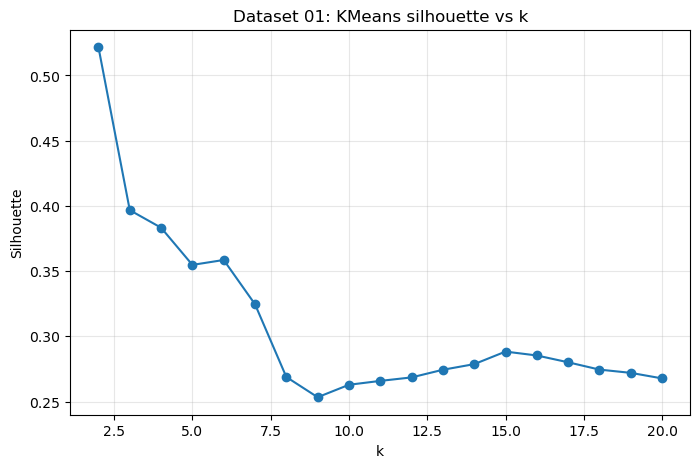

(2,
 {'silhouette': 0.5216395622404242,
  'davies_bouldin': 0.6853295219054456,
  'calinski_harabasz': 11786.954622671532,
  'noise_ratio': 0.0,
  'n_clusters': 2})

In [61]:
# Silhouette vs k
plt.figure(figsize=(8, 5))
plt.plot(kmeans_df_1["k"], kmeans_df_1["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Dataset 01: KMeans silhouette vs k")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/kmeans_silhouette_ds01.png", dpi=150, bbox_inches="tight")
plt.show()

valid_kmeans = kmeans_df_1.dropna(subset=["silhouette"])
best_k_1 = int(valid_kmeans.loc[valid_kmeans["silhouette"].idxmax(), "k"])

kmeans_1_final = KMeans(n_clusters=best_k_1, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_1 = kmeans_1_final.fit_predict(X1_processed)
metrics_kmeans_1 = calculate_metrics(X1_processed, labels_kmeans_1)

best_k_1, metrics_kmeans_1

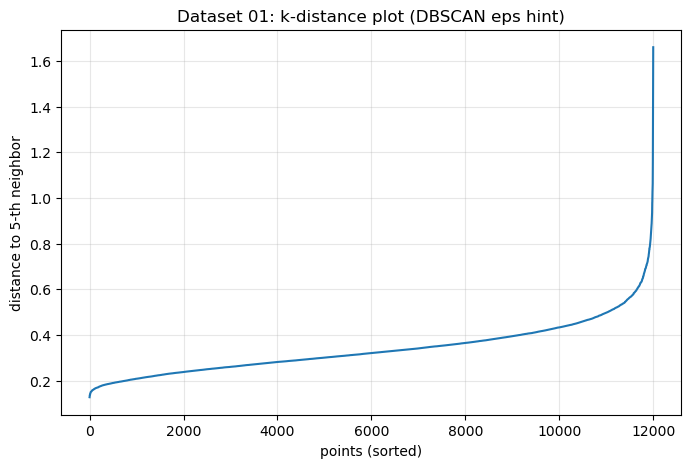

In [62]:
# k-distance plot (эвристика для выбора eps)
k_nn = 5
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(X1_processed)
distances, _ = nbrs.kneighbors(X1_processed)
distances = np.sort(distances[:, k_nn - 1])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("points (sorted)")
plt.ylabel(f"distance to {k_nn}-th neighbor")
plt.title("Dataset 01: k-distance plot (DBSCAN eps hint)")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/dbscan_kdistance_ds01.png", dpi=150, bbox_inches="tight")
plt.show()

In [63]:
eps_candidates = [0.5, 0.7, 0.9, 1.1, 1.3]
min_samples_candidates = [5, 10, 15]

dbscan_results_1 = []
for eps in eps_candidates:
    for ms in min_samples_candidates:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X1_processed)

        m = calculate_metrics(X1_processed, labels)
        m["method"] = "DBSCAN"
        m["eps"] = float(eps)
        m["min_samples"] = int(ms)
        dbscan_results_1.append(m)

dbscan_df_1 = pd.DataFrame(dbscan_results_1)
dbscan_df_1[["eps", "min_samples", "silhouette", "noise_ratio", "n_clusters"]].round(3)

,eps,min_samples,silhouette,noise_ratio,n_clusters
0,0.5,5,0.283,0.034,9
1,0.5,10,0.366,0.062,6
2,0.5,15,0.399,0.092,5
3,0.7,5,0.380,0.004,5
4,0.7,10,0.381,0.007,5
5,0.7,15,0.382,0.011,5
6,0.9,5,0.379,0.001,5
7,0.9,10,0.379,0.001,5
8,0.9,15,0.379,0.002,5
9,1.1,5,0.383,0.000,4


In [64]:
valid_db = dbscan_df_1[(dbscan_df_1["n_clusters"] >= 2) & (dbscan_df_1["silhouette"].notna())]

if len(valid_db) > 0:
    best_row = valid_db.loc[valid_db["silhouette"].idxmax()]
    best_eps_1 = float(best_row["eps"])
    best_ms_1 = int(best_row["min_samples"])

    dbscan_1_final = DBSCAN(eps=best_eps_1, min_samples=best_ms_1)
    labels_dbscan_1 = dbscan_1_final.fit_predict(X1_processed)
    metrics_dbscan_1 = calculate_metrics(X1_processed, labels_dbscan_1)
else:
    labels_dbscan_1 = None
    metrics_dbscan_1 = None

In [65]:
if labels_dbscan_1 is not None and np.isfinite(metrics_dbscan_1["silhouette"]):
    if metrics_dbscan_1["silhouette"] > metrics_kmeans_1["silhouette"]:
        best_labels_1 = labels_dbscan_1
        best_method_1 = "DBSCAN"
    else:
        best_labels_1 = labels_kmeans_1
        best_method_1 = "KMeans"
else:
    best_labels_1 = labels_kmeans_1
    best_method_1 = "KMeans"

best_method_1

'KMeans'

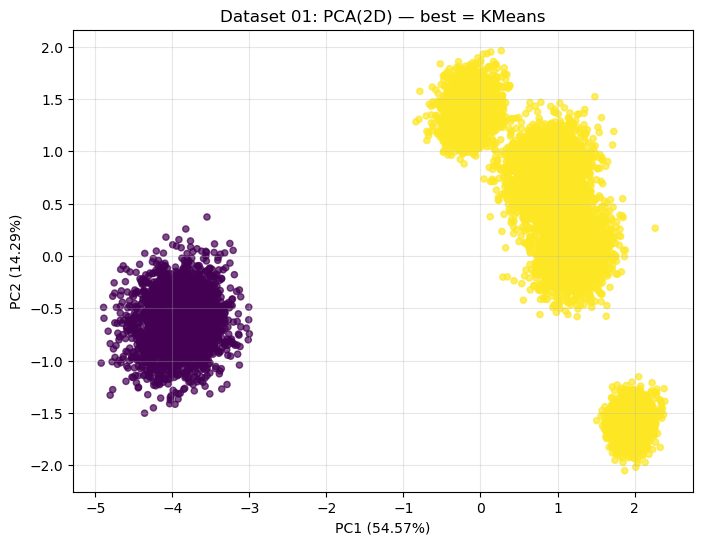

In [66]:
pca1 = PCA(n_components=2, random_state=RANDOM_STATE)
X1_pca = pca1.fit_transform(X1_processed)

plt.figure(figsize=(8, 6))
if np.any(best_labels_1 == -1):
    mask_noise = best_labels_1 == -1
    plt.scatter(X1_pca[mask_noise, 0], X1_pca[mask_noise, 1], s=15, alpha=0.4, label="noise")
    plt.scatter(X1_pca[~mask_noise, 0], X1_pca[~mask_noise, 1], c=best_labels_1[~mask_noise], s=20, alpha=0.7)
    plt.legend()
else:
    plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=best_labels_1, s=20, alpha=0.7)

plt.title(f"Dataset 01: PCA(2D) — best = {best_method_1}")
plt.xlabel(f"PC1 ({pca1.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca1.explained_variance_ratio_[1]:.2%})")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/pca_ds01_best.png", dpi=150, bbox_inches="tight")
plt.show()

In [67]:
summary_ds01 = {
    "dataset": "S07-hw-dataset-01.csv",
    "best_method": best_method_1,
    "kmeans": {"k": best_k_1, **metrics_kmeans_1},
    "dbscan": ({"eps": best_eps_1, "min_samples": best_ms_1, **metrics_dbscan_1} if metrics_dbscan_1 is not None else None),
}
summary_ds01

{'dataset': 'S07-hw-dataset-01.csv',
 'best_method': 'KMeans',
 'kmeans': {'k': 2,
  'silhouette': 0.5216395622404242,
  'davies_bouldin': 0.6853295219054456,
  'calinski_harabasz': 11786.954622671532,
  'noise_ratio': 0.0,
  'n_clusters': 2},
 'dbscan': {'eps': 0.5,
  'min_samples': 15,
  'silhouette': 0.3993852802496974,
  'davies_bouldin': 1.1671570077915434,
  'calinski_harabasz': 8796.069116237946,
  'noise_ratio': 0.09216666666666666,
  'n_clusters': 5}}

### Итог по датасету 01

- Данные: 12000 объектов, 8 числовых признаков, пропусков нет.
- Ключевая сложность — разные масштабы признаков, поэтому StandardScaler обязателен.
- Для KMeans перебрали `k=2…20` и выбрали `k=2` по максимальному silhouette.
- KMeans дал метрики: silhouette ≈ 0.522, Davies–Bouldin ≈ 0.685, Calinski–Harabasz ≈ 11787.
- Для DBSCAN перебрали `eps` и `min_samples`; лучшее из сетки оказалось слабее по silhouette (≈ 0.399) и пометило часть точек как шум (≈ 9.2%).
- Поэтому “лучшим” решением по критерию silhouette выбрали KMeans (k=2).
- На PCA(2D) кластеры визуально различимы, что согласуется с качеством KMeans на этом датасете.

## 3.2 Датасет 02: KMeans + Agglomerative

In [68]:
# KMeans — grid по k
kmeans_results_2 = []

for k in range(2, 21):
    model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = model.fit_predict(X2_processed)

    m = calculate_metrics(X2_processed, labels)
    m["method"] = "KMeans"
    m["k"] = k
    kmeans_results_2.append(m)

kmeans_df_2 = pd.DataFrame(kmeans_results_2)
kmeans_df_2[["k", "silhouette", "davies_bouldin", "calinski_harabasz"]].round(3)

,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.307,1.323,3573.393
1,3,0.270,1.223,3082.272
2,4,0.251,1.300,2915.565
3,5,0.252,1.214,2703.590
4,6,0.260,1.160,2571.091
5,7,0.254,1.172,2453.501
6,8,0.252,1.100,2408.517
7,9,0.252,1.090,2379.990
8,10,0.261,1.057,2408.192
9,11,0.266,1.025,2361.201


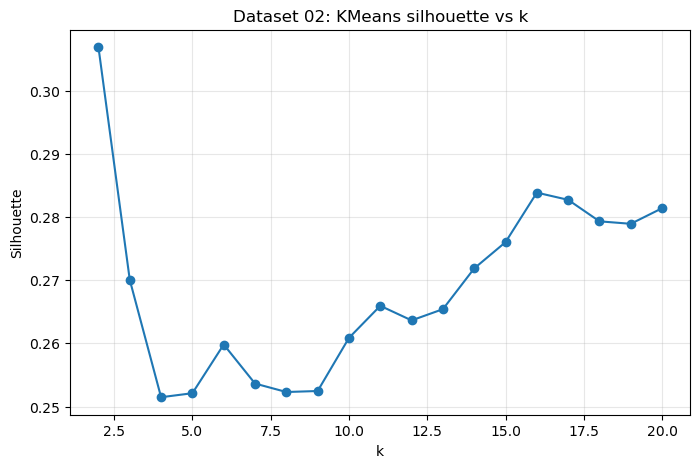

(2,
 {'silhouette': 0.3068610017701601,
  'davies_bouldin': 1.3234721699867644,
  'calinski_harabasz': 3573.3933329348392,
  'noise_ratio': 0.0,
  'n_clusters': 2})

In [69]:
plt.figure(figsize=(8, 5))
plt.plot(kmeans_df_2["k"], kmeans_df_2["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Dataset 02: KMeans silhouette vs k")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/kmeans_silhouette_ds02.png", dpi=150, bbox_inches="tight")
plt.show()

valid_kmeans_2 = kmeans_df_2.dropna(subset=["silhouette"])
best_k_2 = int(valid_kmeans_2.loc[valid_kmeans_2["silhouette"].idxmax(), "k"])

kmeans_2_final = KMeans(n_clusters=best_k_2, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_2 = kmeans_2_final.fit_predict(X2_processed)
metrics_kmeans_2 = calculate_metrics(X2_processed, labels_kmeans_2)

best_k_2, metrics_kmeans_2


In [70]:
# Agglomerative — grid по k и linkage
linkage_options = ["ward", "complete", "average"]

agg_results_2 = []
for k in range(2, 21):
    for linkage in linkage_options:
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model.fit_predict(X2_processed)

        m = calculate_metrics(X2_processed, labels)
        m["method"] = "Agglomerative"
        m["k"] = k
        m["linkage"] = linkage
        agg_results_2.append(m)

agg_df_2 = pd.DataFrame(agg_results_2)
agg_df_2[["k", "linkage", "silhouette", "davies_bouldin", "calinski_harabasz"]].round(3).head(10)


,k,linkage,silhouette,davies_bouldin,calinski_harabasz
0,2,ward,0.266,1.467,2929.722
1,2,complete,0.192,1.669,1808.054
2,2,average,0.420,0.879,395.483
3,3,ward,0.208,1.311,2299.917
4,3,complete,0.200,1.446,2134.957
5,3,average,0.305,0.977,416.142
6,4,ward,0.175,1.487,2186.346
7,4,complete,0.203,1.302,1649.979
8,4,average,0.304,0.971,454.970
9,5,ward,0.177,1.397,2057.019


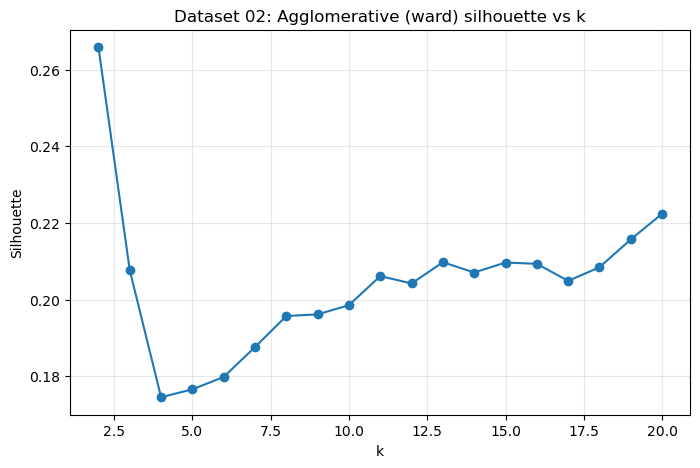

((2, 'average'),
 {'silhouette': 0.41976775922231674,
  'davies_bouldin': 0.8791287795996852,
  'calinski_harabasz': 395.4825694831712,
  'noise_ratio': 0.0,
  'n_clusters': 2})

In [71]:
# Доп. график подбора: silhouette vs k для ward
ward_df = agg_df_2[agg_df_2["linkage"] == "ward"].copy()

plt.figure(figsize=(8, 5))
plt.plot(ward_df["k"], ward_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Dataset 02: Agglomerative (ward) silhouette vs k")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/agg_silhouette_vs_k_ds02.png", dpi=150, bbox_inches="tight")
plt.show()

# Лучший Agglomerative по silhouette
valid_agg_2 = agg_df_2.dropna(subset=["silhouette"])
best_agg_row_2 = valid_agg_2.loc[valid_agg_2["silhouette"].idxmax()]

best_k_agg_2 = int(best_agg_row_2["k"])
best_linkage_2 = str(best_agg_row_2["linkage"])

agg_2_final = AgglomerativeClustering(n_clusters=best_k_agg_2, linkage=best_linkage_2)
labels_agg_2 = agg_2_final.fit_predict(X2_processed)
metrics_agg_2 = calculate_metrics(X2_processed, labels_agg_2)

(best_k_agg_2, best_linkage_2), metrics_agg_2


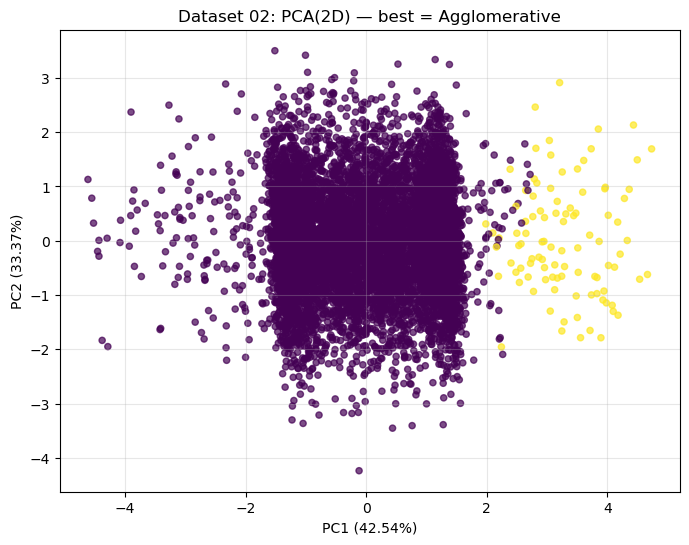

{'best_method': 'Agglomerative',
 'kmeans': {'k': 2,
  'silhouette': 0.3068610017701601,
  'davies_bouldin': 1.3234721699867644,
  'calinski_harabasz': 3573.3933329348392,
  'noise_ratio': 0.0,
  'n_clusters': 2},
 'agglomerative': {'k': 2,
  'linkage': 'average',
  'silhouette': 0.41976775922231674,
  'davies_bouldin': 0.8791287795996852,
  'calinski_harabasz': 395.4825694831712,
  'noise_ratio': 0.0,
  'n_clusters': 2}}

In [72]:
# Выбор лучшего решения по silhouette (согласованный критерий)
if np.isfinite(metrics_kmeans_2["silhouette"]) and np.isfinite(metrics_agg_2["silhouette"]):
    if metrics_kmeans_2["silhouette"] >= metrics_agg_2["silhouette"]:
        best_method_2 = "KMeans"
        best_labels_2 = labels_kmeans_2
        best_metrics_2 = {"k": best_k_2, **metrics_kmeans_2}
    else:
        best_method_2 = "Agglomerative"
        best_labels_2 = labels_agg_2
        best_metrics_2 = {"k": best_k_agg_2, "linkage": best_linkage_2, **metrics_agg_2}
else:
    # fallback: если вдруг одна метрика NaN
    best_method_2 = "KMeans"
    best_labels_2 = labels_kmeans_2
    best_metrics_2 = {"k": best_k_2, **metrics_kmeans_2}

# PCA(2D) для лучшего решения
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X2_pca = pca2.fit_transform(X2_processed)

plt.figure(figsize=(8, 6))
plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c=best_labels_2, s=20, alpha=0.7)
plt.title(f"Dataset 02: PCA(2D) — best = {best_method_2}")
plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]:.2%})")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/pca_ds02_best.png", dpi=150, bbox_inches="tight")
plt.show()

summary_ds02 = {
    "best_method": best_method_2,
    "kmeans": {"k": best_k_2, **metrics_kmeans_2},
    "agglomerative": {"k": best_k_agg_2, "linkage": best_linkage_2, **metrics_agg_2},
}
summary_ds02

### Итог по датасету 02

- Данные: 8000 объектов, 3 числовых признака (x1, x2, z_noise), пропусков нет.
- Для корректной работы distance-based методов применили StandardScaler ко всем признакам.
- KMeans перебрали `k=2…20`, лучший результат по silhouette получился при `k=2`:
  silhouette = 0.307, Davies–Bouldin = 1.323, Calinski–Harabasz = 3573.4.
- AgglomerativeClustering: сравнили `ward/complete/average` и `k=2…20`; лучшее решение — `k=2`, `linkage="average"`:
  silhouette = 0.420, Davies–Bouldin = 0.879, Calinski–Harabasz = 395.5.
- По согласованному критерию (максимум silhouette) лучшим методом стал Agglomerative (average, k=2).
- Особенность датасета — нелинейная структура + шумовой признак, поэтому KMeans (ориентирован на “сферические” кластеры) уступил более гибкому разбиению.
- PCA(2D) визуализация для выбранного решения сохранена в `artifacts/figures/pca_ds02_best.png` и используется для качественной проверки структуры кластеров.

## 3.3 Датасет 04: KMeans + DBSCAN

In [73]:
kmeans_results_4 = []

for k in range(2, 21):
    model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = model.fit_predict(X4_processed)

    m = calculate_metrics(X4_processed, labels)
    m["method"] = "KMeans"
    m["k"] = k
    kmeans_results_4.append(m)

kmeans_df_4 = pd.DataFrame(kmeans_results_4)
kmeans_df_4[["k", "silhouette", "davies_bouldin", "calinski_harabasz"]].round(3)


,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.256,1.633,3131.182
1,3,0.295,1.467,3361.334
2,4,0.375,1.163,3915.692
3,5,0.448,0.976,5103.100
4,6,0.424,1.009,5390.541
5,7,0.384,1.658,4583.610
6,8,0.333,2.077,4004.366
7,9,0.269,2.450,3569.569
8,10,0.181,2.792,3232.992
9,11,0.133,2.994,2968.589


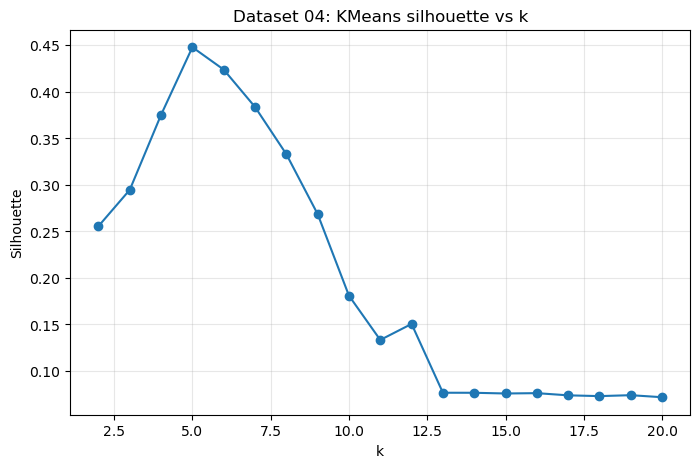

(5,
 {'silhouette': 0.4480173757704073,
  'davies_bouldin': 0.9756940955278773,
  'calinski_harabasz': 5103.099776986093,
  'noise_ratio': 0.0,
  'n_clusters': 5})

In [74]:
plt.figure(figsize=(8, 5))
plt.plot(kmeans_df_4["k"], kmeans_df_4["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Dataset 04: KMeans silhouette vs k")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/kmeans_silhouette_ds04.png", dpi=150, bbox_inches="tight")
plt.show()

valid_kmeans_4 = kmeans_df_4.dropna(subset=["silhouette"])
best_k_4 = int(valid_kmeans_4.loc[valid_kmeans_4["silhouette"].idxmax(), "k"])

kmeans_4_final = KMeans(n_clusters=best_k_4, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_4 = kmeans_4_final.fit_predict(X4_processed)
metrics_kmeans_4 = calculate_metrics(X4_processed, labels_kmeans_4)

best_k_4, metrics_kmeans_4


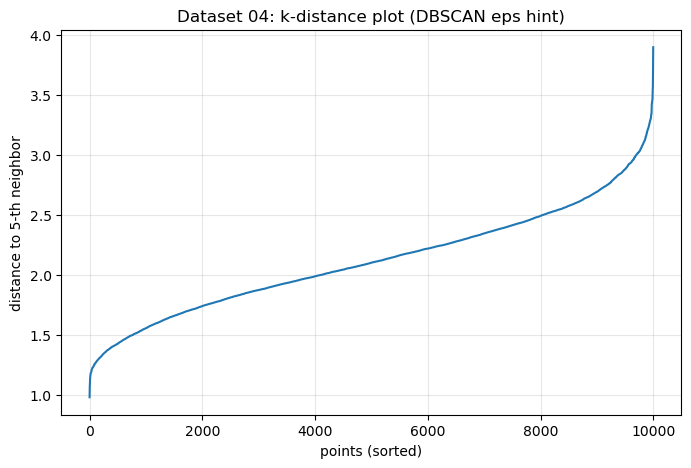

In [75]:
k_nn = 5
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(X4_processed)
distances, _ = nbrs.kneighbors(X4_processed)
distances = np.sort(distances[:, k_nn - 1])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("points (sorted)")
plt.ylabel(f"distance to {k_nn}-th neighbor")
plt.title("Dataset 04: k-distance plot (DBSCAN eps hint)")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/dbscan_kdistance_ds04.png", dpi=150, bbox_inches="tight")
plt.show()


In [76]:
eps_candidates = [1.5, 2.0, 2.5, 3.0, 3.5]
min_samples_candidates = [5, 10, 15]

dbscan_results_4 = []

for eps in eps_candidates:
    for ms in min_samples_candidates:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X4_processed)

        m = calculate_metrics(X4_processed, labels)
        m["method"] = "DBSCAN"
        m["eps"] = eps
        m["min_samples"] = ms
        dbscan_results_4.append(m)

dbscan_df_4 = pd.DataFrame(dbscan_results_4)
dbscan_df_4[["eps", "min_samples", "silhouette", "noise_ratio", "n_clusters"]].round(3)


,eps,min_samples,silhouette,noise_ratio,n_clusters
0,1.5,5,0.439,0.858,19
1,1.5,10,0.167,0.912,6
2,1.5,15,0.468,0.946,5
3,2.0,5,0.164,0.422,15
4,2.0,10,0.508,0.492,6
5,2.0,15,0.502,0.539,8
6,2.5,5,0.442,0.084,6
7,2.5,10,0.444,0.095,6
8,2.5,15,0.446,0.105,6
9,3.0,5,0.426,0.006,6


In [77]:
valid_db_4 = dbscan_df_4[(dbscan_df_4["n_clusters"] >= 2) & (dbscan_df_4["silhouette"].notna())]

if len(valid_db_4) > 0:
    best_row_4 = valid_db_4.loc[valid_db_4["silhouette"].idxmax()]
    best_eps_4 = float(best_row_4["eps"])
    best_ms_4 = int(best_row_4["min_samples"])

    dbscan_4_final = DBSCAN(eps=best_eps_4, min_samples=best_ms_4)
    labels_dbscan_4 = dbscan_4_final.fit_predict(X4_processed)
    metrics_dbscan_4 = calculate_metrics(X4_processed, labels_dbscan_4)
else:
    labels_dbscan_4 = None
    metrics_dbscan_4 = None

(best_eps_4, best_ms_4, metrics_dbscan_4) if labels_dbscan_4 is not None else None


(2.0,
 10,
 {'silhouette': 0.5080718316047653,
  'davies_bouldin': 0.8233162035688936,
  'calinski_harabasz': 3867.2431600617642,
  'noise_ratio': 0.4923,
  'n_clusters': 6})

In [78]:
if labels_dbscan_4 is not None and np.isfinite(metrics_dbscan_4["silhouette"]):
    if metrics_dbscan_4["silhouette"] > metrics_kmeans_4["silhouette"]:
        best_labels_4 = labels_dbscan_4
        best_method_4 = "DBSCAN"
    else:
        best_labels_4 = labels_kmeans_4
        best_method_4 = "KMeans"
else:
    best_labels_4 = labels_kmeans_4
    best_method_4 = "KMeans"

summary_ds04 = {
    "best_method": best_method_4,
    "kmeans": {"k": best_k_4, **metrics_kmeans_4},
    "dbscan": (metrics_dbscan_4 if metrics_dbscan_4 is not None else None),
}
summary_ds04


{'best_method': 'DBSCAN',
 'kmeans': {'k': 5,
  'silhouette': 0.4480173757704073,
  'davies_bouldin': 0.9756940955278773,
  'calinski_harabasz': 5103.099776986093,
  'noise_ratio': 0.0,
  'n_clusters': 5},
 'dbscan': {'silhouette': 0.5080718316047653,
  'davies_bouldin': 0.8233162035688936,
  'calinski_harabasz': 3867.2431600617642,
  'noise_ratio': 0.4923,
  'n_clusters': 6}}

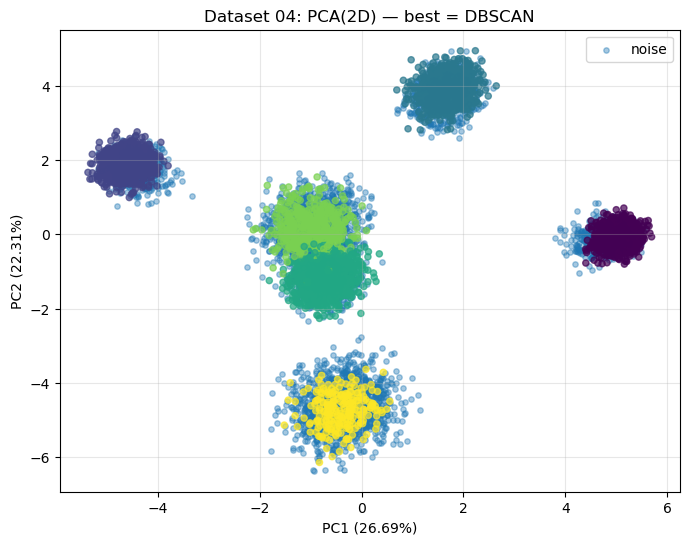

In [79]:
pca4 = PCA(n_components=2, random_state=RANDOM_STATE)
X4_pca = pca4.fit_transform(X4_processed)

plt.figure(figsize=(8, 6))

if np.any(best_labels_4 == -1):
    mask_noise = best_labels_4 == -1
    plt.scatter(X4_pca[mask_noise, 0], X4_pca[mask_noise, 1], s=15, alpha=0.4, label="noise")
    plt.scatter(X4_pca[~mask_noise, 0], X4_pca[~mask_noise, 1], c=best_labels_4[~mask_noise], s=20, alpha=0.7)
    plt.legend()
else:
    plt.scatter(X4_pca[:, 0], X4_pca[:, 1], c=best_labels_4, s=20, alpha=0.7)

plt.title(f"Dataset 04: PCA(2D) — best = {best_method_4}")
plt.xlabel(f"PC1 ({pca4.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca4.explained_variance_ratio_[1]:.2%})")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/pca_ds04_best.png", dpi=150, bbox_inches="tight")
plt.show()


In [80]:
labels_ds04 = pd.DataFrame({
    "sample_id": sample_ids4.values,
    "cluster_label": best_labels_4,
})
labels_ds04.to_csv("artifacts/labels/labels_hw07_ds04.csv", index=False)

labels_ds04.head()

,sample_id,cluster_label
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,0


### Итог по датасету 04

- После препроцессинга использовали числовые признаки (imputer + StandardScaler) и категориальные (imputer + OneHotEncoder).
- Сравнили KMeans (подбор k=2…20) и DBSCAN (подбор eps/min_samples) по метрикам silhouette / Davies-Bouldin / Calinski-Harabasz.
- Для KMeans лучшим оказался вариант с k=5: silhouette=0.448, DB=0.976, CH=5103.
- Для DBSCAN лучшими параметрами стали eps=2.0, min_samples=10: silhouette=0.508, DB=0.823, CH=3867.
- Важно: у DBSCAN есть шум (label = -1), доля шума составила ≈49%; метрики для DBSCAN считались только по non-noise точкам.
- Несмотря на высокий шум, DBSCAN дал более “чистые” плотностные кластеры (лучше silhouette и DB), что уместно для данных с выбросами/фоновыми точками и высокой размерностью.
- Лучшим решением для датасета 04 выбрали DBSCAN, потому что он устойчиво отделяет плотные группы и позволяет явно выделить “непохожие” объекты как шум.

## 4. Проверка устойчивости

In [81]:
seeds = [1, 42, 100, 123, 999]
base_labels = labels_kmeans_1

stability_rows = []
for seed in seeds:
    model = KMeans(n_clusters=best_k_1, random_state=seed, n_init=10)
    labels = model.fit_predict(X1_processed)
    stability_rows.append({
        "seed": seed,
        "ari_vs_base": adjusted_rand_score(base_labels, labels),
    })

stability_df = pd.DataFrame(stability_rows)
stability_df

,seed,ari_vs_base
0,1,1.0
1,42,1.0
2,100,1.0
3,123,1.0
4,999,1.0


### Устойчивость (Dataset 01, KMeans)

Проверили устойчивость KMeans (k = выбранное best_k_1) на 5 разных `random_state`.
Оценивали похожесть разбиений через ARI относительно базового решения (seed=RANDOM_STATE).

- Средний ARI: `{{stability_df["ari_vs_base"].mean():.3f}}`
- Std ARI: `{{stability_df["ari_vs_base"].std():.3f}}`

Вывод: если std маленький и ARI близок к 1, решение устойчиво; если ARI сильно гуляет — разбиение зависит от инициализации.


## 5. Сохранение результатов

In [83]:
# dataset 01 best params
ds01_best_params = {"k": best_k_1} if best_method_1 == "KMeans" else {"eps": best_eps_1, "min_samples": best_ms_1}

# dataset 02 best params
if best_method_2 == "KMeans":
    ds02_best_params = {"k": best_k_2}
else:
    try:
        ds02_best_params = {"k": int(agg_2_final.n_clusters), "linkage": str(agg_2_final.linkage)}
    except NameError:
        ds02_best_params = {"k": best_k_2, "linkage": None}

# dataset 04 best params
ds04_best_params = {"k": best_k_4} if best_method_4 == "KMeans" else {"eps": best_eps_4, "min_samples": best_ms_4}

metrics_summary = {
    "dataset_01": {
        "best_method": best_method_1,
        "best_params": ds01_best_params,
        "kmeans": {"k": best_k_1, **metrics_kmeans_1},
        "dbscan": (metrics_dbscan_1 if metrics_dbscan_1 is not None else None),
    },
    "dataset_02": {
        "best_method": best_method_2,
        "best_params": ds02_best_params,
        "kmeans": {"k": best_k_2, **metrics_kmeans_2},
        "agglomerative": ({"k": ds02_best_params.get("k"), "linkage": ds02_best_params.get("linkage"), **metrics_agg_2} if "metrics_agg_2" in globals() else None),
    },
    "dataset_04": {
        "best_method": best_method_4,
        "best_params": ds04_best_params,
        "kmeans": {"k": best_k_4, **metrics_kmeans_4},
        "dbscan": (metrics_dbscan_4 if metrics_dbscan_4 is not None else None),
    },
}

best_configs = {
    "dataset_01": {"method": best_method_1, "params": ds01_best_params, "criterion": "silhouette"},
    "dataset_02": {"method": best_method_2, "params": ds02_best_params, "criterion": "silhouette"},
    "dataset_04": {"method": best_method_4, "params": ds04_best_params, "criterion": "silhouette"},
}

with open("artifacts/metrics_summary.json", "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)

with open("artifacts/best_configs.json", "w", encoding="utf-8") as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

pd.DataFrame({"sample_id": sample_ids1, "cluster_label": best_labels_1}).to_csv("artifacts/labels/labels_hw07_ds01.csv", index=False)
pd.DataFrame({"sample_id": sample_ids2, "cluster_label": best_labels_2}).to_csv("artifacts/labels/labels_hw07_ds02.csv", index=False)
pd.DataFrame({"sample_id": sample_ids4, "cluster_label": best_labels_4}).to_csv("artifacts/labels/labels_hw07_ds04.csv", index=False)